<a href="https://colab.research.google.com/github/nevermess/Hand-Written-Digit-Recogniser/blob/master/Final_keras_hand_written.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras

In [0]:
from keras.datasets import mnist
(X_train,Y_train),(X_test,Y_test)=mnist.load_data()
print(X_train.shape,Y_train.shape)

Using TensorFlow backend.


11493376/11490434 [==============================] - 2s 0us/step
(60000, 28, 28) (60000,)


Now we need to preprocess our dataset which includes normalizing pixel values by dividing it by 255 and changing the labels into one hot encoding and futhermore I'm using 10,000 data from train set as cross validation set.

In [0]:
X_train=X_train/255.
Y_train=tf.keras.utils.to_categorical(Y_train)
X_test=X_test/255.
x_train=X_train[0:50000]
x_cv=X_train[50000:60000]
y_train=Y_train[0:50000]
y_cv=Y_train[50000:60000]
print(x_train.shape,x_cv.shape,y_train.shape,y_cv.shape)

(50000, 28, 28) (10000, 28, 28) (50000, 10) (10000, 10)


Now the next code block defines a function show_random() to show some of examples that are in our dataset which will be further used for showing random examples when we predict from our test class.

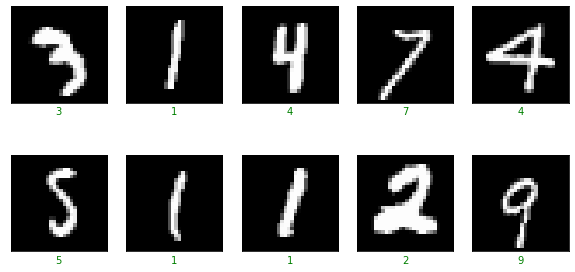

In [0]:
def show_random(x,y,p):
  indices=np.random.choice(range(x.shape[0]),10,replace=False)
  x=x.reshape(x.shape[0],28,28)
  x=x[indices]
  y=y[indices]
  p=p[indices]
  plt.figure(figsize=(10,5))
  for i in range(10):
    plt.subplot(2,5,1+i)
    plt.imshow(x[i],cmap='gray')
    plt.xticks([])
    plt.yticks([])
    col='green'if np.argmax(y[i])==np.argmax(p[i]) else 'red'
    plt.xlabel(np.argmax(p[i]),color=col)
  plt.show()
show_random(x_train,y_train,y_train)

In [0]:
x_train=x_train.reshape(50000,28,28,1)
x_cv=x_cv.reshape(10000,28,28,1)

since we are using convolution we need to provide the number of channels which is missing in mnist dataset ,so to combat we reshape the set with the last axis being 1 as it is gray scale image.

In [0]:
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dropout,Input,BatchNormalization,Flatten,Dense,AveragePooling2D

In [0]:
def create_model():
  def add_conv_layer(model,filters_count):
    model.add(Conv2D(filters_count,kernel_size=3,activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters_count,kernel_size=3,activation='relu',padding='valid'))
    model.add(MaxPooling2D((3,3),strides=1))
    model.add(Dropout(0.5))
    return model
  def add_bottle_neck_conv(model,filters_count):
    model.add(Conv2D(filters_count[0],kernel_size=1,activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters_count[1],kernel_size=3,activation='relu',padding='same'))
    model.add(MaxPooling2D(2))
    model.add(Dropout(0.4))
    return model

  def insert_Res(h,w,c,filters,model):
    
    x_input=Input([h,w,c])
    x=x_input
    x=Conv2D(filters[0],kernel_size=3,activation='relu',padding='same')(x)
    x=BatchNormalization()(x)
    x=MaxPooling2D((3,3),padding='same')(x)
    x_short=x
    x=Conv2D(filters[0],kernel_size=3,activation='relu',padding='same')(x)
    x=BatchNormalization()(x)
    #x=AveragePooling2D((3,3),padding='same')(x)
    x=x+x_short  
    x=Conv2D(filters[1],(3,3),activation='relu')(x)
    x=BatchNormalization()(x)
    x=(MaxPooling2D((3,3),padding='same')(x))
    submodel=tf.keras.Model(inputs=x_input,outputs=x,name='submodel')
    model.add(submodel)
    return model

  def add_inception_layer(h,w,c,filters,model):
    x_input=Input([h,w,c])
    x=x_input
    x=Conv2D(filters[0],kernel_size=(1,1),activation='relu')(x)
    x1=MaxPooling2D((3,3),padding='same')(x)
    x2=Conv2D(filters[1],kernel_size=(3,3),activation='relu',padding='same')(x)
    x2=MaxPooling2D((3,3),padding='same')(x2)
    x3=Conv2D(filters[2],kernel_size=(5,5),activation='relu',padding='same')(x)
    x3=MaxPooling2D((3,3),padding='same')(x3)
    x=tf.keras.layers.concatenate([x1,x2,x3],axis=3)
    submodel=tf.keras.Model(inputs=x_input,outputs=x,name='submodel'+str(np.random.randint(10)))
    model.add(submodel)
    return model

  model=tf.keras.models.Sequential()
  model.add(Input(shape=(28,28,1)))
  #a=np.array([4,16,10])
  #model=add_inception_layer(28,28,1,a,model)
  model=add_conv_layer(model,16)
  a=np.array([8,64])
  model=add_bottle_neck_conv(model,a)
  a=np.array([128,256])              #
  model=insert_Res(12,12,64,a,model) #
  #model=add_conv_layer(model,128)
  model.add(Flatten())
  model.add(Dense(128,activation='relu'))
  model.add(Dropout(0.4))
  model.add(Dense(10,activation='softmax'))
  model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
  return model

model=create_model()
model.summary()  


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 16)        64        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 16)        2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 8)         136       
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 8)         3

In [0]:
h=model.fit(x_train,y_train,validation_data=(x_cv,y_cv),epochs=10,batch_size=64)

Epoch 1/10
782/782 [==============================] - 21s 26ms/step - loss: 0.3793 - accuracy: 0.8861 - val_loss: 0.5604 - val_accuracy: 0.8604
Epoch 2/10
782/782 [==============================] - 20s 26ms/step - loss: 0.1244 - accuracy: 0.9640 - val_loss: 0.1655 - val_accuracy: 0.9560
Epoch 3/10
782/782 [==============================] - 20s 25ms/step - loss: 0.0979 - accuracy: 0.9722 - val_loss: 0.1174 - val_accuracy: 0.9750
Epoch 4/10
782/782 [==============================] - 20s 25ms/step - loss: 0.0810 - accuracy: 0.9771 - val_loss: 0.0610 - val_accuracy: 0.9851
Epoch 5/10
782/782 [==============================] - 20s 25ms/step - loss: 0.0723 - accuracy: 0.9795 - val_loss: 0.0726 - val_accuracy: 0.9827
Epoch 6/10
782/782 [==============================] - 20s 25ms/step - loss: 0.0621 - accuracy: 0.9825 - val_loss: 0.0907 - val_accuracy: 0.9778
Epoch 7/10
782/782 [==============================] - 20s 26ms/step - loss: 0.0573 - accuracy: 0.9832 - val_loss: 0.0554 - val_accuracy:

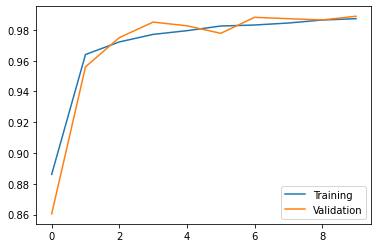

In [0]:
accs=h.history['accuracy']
val_accs=h.history['val_accuracy']
plt.plot(range(len(accs)),accs,label='Training')
plt.plot(range(len(val_accs)),val_accs,label='Validation')
plt.legend()
plt.show()

In [0]:
model.save('/content/drive/My Drive/Colab Notebooks/model2.h5')

In [0]:
pred=model.predict(X_test.reshape(10000,28,28,1))
Y_test=tf.keras.utils.to_categorical(Y_test)

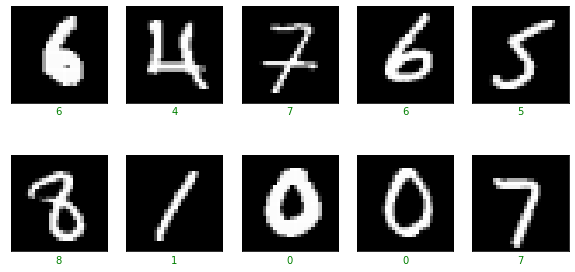

In [0]:
show_random(X_test,Y_test,pred)